# Normalizing Flows Tutorial Part 1

2D invertible MLP on a toy dataset.

Copyright 2018 Eric Jang

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_probability as tfp
tfd = tfp.distributions
tfb = tfp.bijectors

In [2]:
tf.set_random_seed(0)

In [3]:
sess = tf.InteractiveSession()

In [4]:
batch_size=512
DTYPE=tf.float32
NP_DTYPE=np.float32

## Target Density

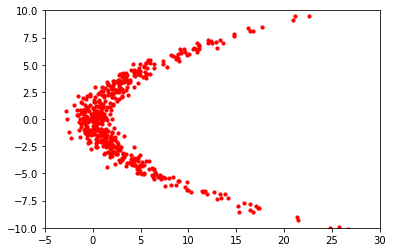

In [5]:
DATASET = 1
if DATASET == 0:
    mean = [0.4, 1]
    A = np.array([[2, .3], [-1., 4]])
    cov = A.T.dot(A)
    print(mean)
    print(cov)
    X = np.random.multivariate_normal(mean, cov, 2000)
    plt.scatter(X[:, 0], X[:, 1], s=10, color='red')
    dataset = tf.data.Dataset.from_tensor_slices(X.astype(NP_DTYPE))
    dataset = dataset.repeat()
    dataset = dataset.shuffle(buffer_size=X.shape[0])
    dataset = dataset.prefetch(3 * batch_size)
    dataset = dataset.batch(batch_size)
    data_iterator = dataset.make_one_shot_iterator()
    x_samples = data_iterator.get_next()
elif DATASET == 1:
    x2_dist = tfd.Normal(loc=0., scale=4.)
    x2_samples = x2_dist.sample(batch_size)
    x1 = tfd.Normal(loc=.25 * tf.square(x2_samples),
                    scale=tf.ones(batch_size, dtype=DTYPE))
    x1_samples = x1.sample()
    x_samples = tf.stack([x1_samples, x2_samples], axis=1)
    np_samples = sess.run(x_samples)
    plt.scatter(np_samples[:, 0], np_samples[:, 1], s=10, color='red')
    plt.xlim([-5, 30])
    plt.ylim([-10, 10])

## Construct Flow

In [6]:
base_dist = tfd.MultivariateNormalDiag(loc=tf.zeros([2], DTYPE))

In [7]:
# quite easy to interpret - multiplying by alpha causes a contraction in volume.
class LeakyReLU(tfb.Bijector):
    def __init__(self, alpha=0.5, validate_args=False, name="leaky_relu"):
        super(LeakyReLU, self).__init__(
            forward_min_event_ndims=0, validate_args=validate_args, name=name)
        self.alpha = alpha

    def _forward(self, x):
        return tf.where(tf.greater_equal(x, 0), x, self.alpha * x)

    def _inverse(self, y):
        return tf.where(tf.greater_equal(y, 0), y, 1. / self.alpha * y)

    def _inverse_log_det_jacobian(self, y):
        I = tf.ones_like(y)
        J_inv = tf.where(tf.greater_equal(y, 0), I, 1.0 / self.alpha * I)
        # abs is actually redundant here, since this det Jacobian is > 0
        log_abs_det_J_inv = tf.log(tf.abs(J_inv))
        return log_abs_det_J_inv

In [8]:
d, r = 2, 2
bijectors = []
num_layers = 6
for i in range(num_layers):
    with tf.variable_scope('bijector_%d' % i):
        V = tf.get_variable('V', [d, r], dtype=DTYPE)  # factor loading
        shift = tf.get_variable('shift', [d], dtype=DTYPE)  # affine shift
        L = tf.get_variable('L', [d * (d + 1) / 2],
                            dtype=DTYPE)  # lower triangular
        bijectors.append(tfb.Affine(
            scale_tril=tfd.fill_triangular(L),
            scale_perturb_factor=V,
            shift=shift,
        ))
        alpha = tf.abs(tf.get_variable('alpha', [], dtype=DTYPE)) + .01
        bijectors.append(LeakyReLU(alpha=alpha))
# Last layer is affine. Note that tfb.Chain takes a list of bijectors in the *reverse* order
# that they are applied..
mlp_bijector = tfb.Chain(
    list(reversed(bijectors[:-1])), name='2d_mlp_bijector')

In [9]:
dist = tfd.TransformedDistribution(
    distribution=base_dist,
    bijector=mlp_bijector
)

## Visualization (before training)

In [10]:
# visualization
x = base_dist.sample(512)
samples = [x]
names = [base_dist.name]
for bijector in reversed(dist.bijector.bijectors):
    x = bijector.forward(x)
    samples.append(x)
    names.append(bijector.name)

In [11]:
sess.run(tf.global_variables_initializer())

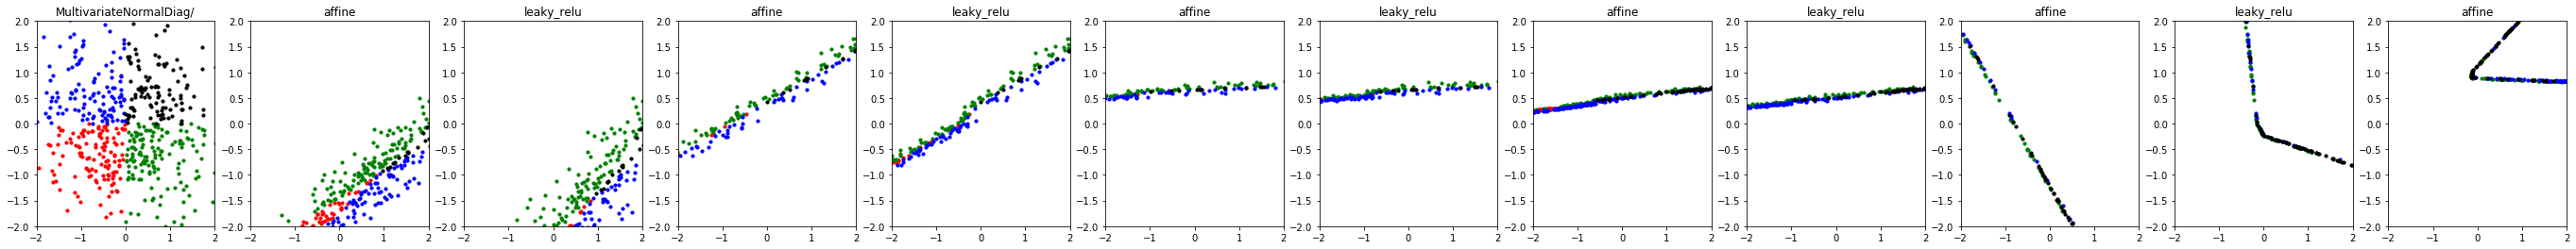

In [12]:
results = sess.run(samples)
f, arr = plt.subplots(1, len(results), figsize=(4 * (len(results)), 4))
X0 = results[0]
for i in range(len(results)):
    X1 = results[i]
    idx = np.logical_and(X0[:, 0] < 0, X0[:, 1] < 0)
    arr[i].scatter(X1[idx, 0], X1[idx, 1], s=10, color='red')
    idx = np.logical_and(X0[:, 0] > 0, X0[:, 1] < 0)
    arr[i].scatter(X1[idx, 0], X1[idx, 1], s=10, color='green')
    idx = np.logical_and(X0[:, 0] < 0, X0[:, 1] > 0)
    arr[i].scatter(X1[idx, 0], X1[idx, 1], s=10, color='blue')
    idx = np.logical_and(X0[:, 0] > 0, X0[:, 1] > 0)
    arr[i].scatter(X1[idx, 0], X1[idx, 1], s=10, color='black')
    arr[i].set_xlim([-2, 2])
    arr[i].set_ylim([-2, 2])
    arr[i].set_title(names[i])

## Optimize Flow

In [13]:
loss = -tf.reduce_mean(dist.log_prob(x_samples))
train_op = tf.train.AdamOptimizer(1e-3).minimize(loss)

In [14]:
sess.run(tf.global_variables_initializer())

In [ ]:
NUM_STEPS = int(1e5)
global_step = []
np_losses = []
for i in range(NUM_STEPS):
    _, np_loss = sess.run([train_op, loss])
    if i % 1000 == 0:
        global_step.append(i)
        np_losses.append(np_loss)
    if i % int(1e4) == 0:
        print(i, np_loss)
start = 10
plt.plot(np_losses[start:])

0 1.1126e+09
10000 2210.79
20000 15.2722
30000 6.76039


In [ ]:
results = sess.run(samples)
f, arr = plt.subplots(1, len(results), figsize=(4 * (len(results)), 4))
X0 = results[0]
for i in range(len(results)):
    X1 = results[i]
    idx = np.logical_and(X0[:, 0] < 0, X0[:, 1] < 0)
    arr[i].scatter(X1[idx, 0], X1[idx, 1], s=10, color='red')
    idx = np.logical_and(X0[:, 0] > 0, X0[:, 1] < 0)
    arr[i].scatter(X1[idx, 0], X1[idx, 1], s=10, color='green')
    idx = np.logical_and(X0[:, 0] < 0, X0[:, 1] > 0)
    arr[i].scatter(X1[idx, 0], X1[idx, 1], s=10, color='blue')
    idx = np.logical_and(X0[:, 0] > 0, X0[:, 1] > 0)
    arr[i].scatter(X1[idx, 0], X1[idx, 1], s=10, color='black')
    arr[i].set_xlim([-2, 2])
    arr[i].set_ylim([-2, 2])
    arr[i].set_title(names[i])
plt.savefig('toy2d_flow.png', dpi=300)

In [ ]:
X1 = sess.run(dist.sample(4000))
plt.scatter(X1[:, 0], X1[:, 1], color='red', s=2)
arr[i].set_xlim([-2.5, 2.5])
arr[i].set_ylim([-.5, .5])
plt.savefig('toy2d_out.png', dpi=300)